# Prepare the dataset

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

### Merge two data sets

In [3]:
df = pd.read_csv('dataset/tmdb_5000_movies_nonull.csv')
# df_movies.loc[:,['id', 'keywords', 'genres', 'title']]
df_credits = pd.read_csv('dataset/tmdb_5000_credits.csv')
credits_sub = df_credits.loc[:, ['movie_id', 'cast']].rename(columns={
                                                             'movie_id': 'id'})

df = df[['id', 'budget', 'genres', 'keywords', 'original_language',
         'overview', 'popularity', 'production_companies',
         'production_countries', 'release_date', 'revenue', 'runtime',
         'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count']]
df = df.merge(credits_sub)

# df.sort_values(by='release_date', ascending=False).head(10)

In [4]:
df.shape

(4799, 18)

In [5]:
df.head(5)

,id,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast
0,19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [6]:
# drop movies with no genre info
for i, row in df.iterrows():
    if row['genres'] == '[]':
        df.drop(i, inplace=True)
df = df.dropna()

In [7]:
df.head(5)

,id,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast
0,19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


### Drop movies with no genres information

In [8]:
# drop movies with no genre info
for i, row in df.iterrows():
    if row['genres'] == '[]':
        df.drop(i, inplace=True)
df = df.dropna()

In [12]:
all_genres = defaultdict(int)

for row in df.genres:
    for item in json.loads(row):
#         print(item)
        all_genres[item['name']] += 1

genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 1801),
 ('Comedy', 1442),
 ('Thriller', 1151),
 ('Action', 1025),
 ('Romance', 726),
 ('Adventure', 720),
 ('Crime', 627),
 ('Science Fiction', 488),
 ('Horror', 470),
 ('Family', 437),
 ('Fantasy', 388),
 ('Mystery', 316),
 ('Animation', 201),
 ('History', 153),
 ('Music', 149),
 ('War', 115),
 ('Western', 69),
 ('Documentary', 56),
 ('Foreign', 14),
 ('TV Movie', 3)]

In [13]:
# All cast: # of movies
cast_all = defaultdict(int)

for item in df.cast:
    for p in json.loads(item):
        cast_all[p['name']] += 1

sorted(cast_all.items(), key=lambda x: x[1], reverse=True)[:10]

[('Samuel L. Jackson', 57),
 ('Robert De Niro', 52),
 ('Bruce Willis', 47),
 ('Morgan Freeman', 46),
 ('Matt Damon', 46),
 ('Liam Neeson', 41),
 ('Johnny Depp', 39),
 ('Steve Buscemi', 39),
 ('Owen Wilson', 37),
 ('John Goodman', 36)]

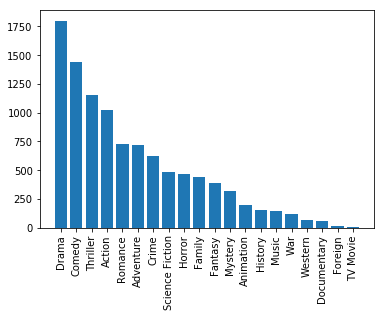

In [14]:
plt.bar(x = [x[0] for x in genres_list], height = [y[1] for y in genres_list])
plt.xticks(rotation=90)
plt.show()

### Modify df

In [15]:
def convert_list(cell):
    """convert the json format to a list of categories"""
    kw_list = []
    for kw in json.loads(cell):
        kw_list.append(kw['name'])
    return kw_list


def larger_n(col, n):
    """filter the column"""
    keywords = defaultdict(int)
    for row in df[col]:
        row = json.loads(row)
        for entry in row:
            keywords[entry['name']] += 1
    kw_cnt = sorted(keywords.items(), key=lambda x: -x[1])
    return [kw[0] for kw in kw_cnt if kw[1] >= n]


def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1:
            female += 1
        elif item['gender'] == 2:
            male += 1
        else:
            continue
    return female, male


def concat_names(cell):
    """Concatenate first names and last names"""
    names = []
    for name in cell:
        names.append(name.replace(' ', ''))
    return names


def list2str(cell):
    """Convert list to string"""
    return ' '.join(cell)


def transform_cols(df, cols_to_transform):
    """Transform columns of a dataframe.
    cols_to_transform should be a dict(col_name: filter value n)
    """
    for col_name in cols_to_transform.keys():
        larger_col = larger_n(col_name, cols_to_transform[col_name])
        if col_name == 'cast':
            gen = df[col_name].apply(extract_gender)
            df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]+0.001))
            df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]+0.001))

        df[col_name] = df[col_name].apply(convert_list)\
            .apply(lambda cell: [kw for kw in cell if kw in larger_col])
    return df

In [16]:
cols_to_transform = {'keywords': 30,
                     'genres': 0,
                     'production_companies': 5,
                     'production_countries': 3,
                     'spoken_languages': 10,
                     'cast': 2}

df_movies = transform_cols(df, cols_to_transform)

In [17]:
df_movies = df_movies[df_movies["subtitles"] != '']
df_movies = df_movies.reset_index(drop=True)
df_movies.head(10)

KeyError: 'subtitles'

## Pairwise analysis of Movie Genres


Put highly dependent labels into the same cluster, so that we can assume the four resulting clusters are approximately independent.


*Source: https://spandan-madan.github.io/DeepLearningProject/*

In [ ]:
import itertools

# This function just generates all possible pairs of movies
def list2pairs(genres):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(genres, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for genre in genres:
        pairs.append([genre, genre])
    return pairs

In [ ]:
# get all genre lists pairs from all movies
allPairs = []
for cell in df.genres:
    allPairs.extend(list2pairs(cell))
    
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

In [ ]:
import seaborn as sns

# shows how often the genres occur together
annot_lookup = []
for i in range(len(nr_ids)):
    annot_lookup.append(nr_ids[i])

sns.heatmap(visGrid, xticklabels=annot_lookup, yticklabels=annot_lookup)

In [ ]:
# co-cluster the genres
# n_clusters=4 has the best result
from sklearn.cluster import SpectralCoclustering

model = SpectralCoclustering(n_clusters=4, svd_method='arpack', random_state=0)
model.fit(visGrid)

fit_data = visGrid[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

annot_lookup_sorted = []
for i in np.argsort(model.row_labels_):
    annot_lookup_sorted.append(nr_ids[i])
    
sns.heatmap(fit_data, xticklabels=annot_lookup_sorted, yticklabels=annot_lookup_sorted, annot=False)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

**Four clusters:**  
+ **Exciting**: Thriller, Horror, Action, Adventure, Sci-Fi, Crime, Mystery, Fantasy    
+ **Uplifting**: Drama, Romance, Comedy, Family  
+ **Reality:** Documentary, War, History, Foreign, Music
+ **Others:** Western, TV Movie, Animation

## Change genres to four new subsets

## Cast+gender vs. Genres

In [ ]:
for i, row in df.iterrows():
    df.at[i, 'cast'] = ' '.join(row['cast'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, hamming_loss
from sklearn.metrics import roc_auc_score

In [ ]:
# One-Hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(df.genres)
train_data, test_data, train_labels, test_labels = train_test_split(df.iloc[:, 3:], mlb.transform(df.genres),
                                                                    test_size=0.2, random_state=42)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
train_cast_vect = vectorizer.fit_transform(train_data.iloc[:, 0])
test_cast_vect = vectorizer.transform(test_data.iloc[:, 0])

train_features = np.concatenate((train_cast_vect.toarray(), np.asarray(train_data.iloc[:, 1:])), axis=1)
test_features = np.concatenate((test_cast_vect.toarray(), np.asarray(test_data.iloc[:, 1:])), axis=1)

### Cast+gender (pretty slow)

It's interesting that I only added two columns (female_proportion and male_proportion) to the vectorized cast names, but the running time of fitting a model takes much longer than using only the cast names.  

In [ ]:
# gender+cast
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance

# parameters = {'criterion': ['gini', 'entropy']}
# gridCV = GridSearchCV(DecisionTreeClassifier(max_depth=3), parameters,
#                       scoring=make_scorer(accuracy_score), 
#                       cv=10, return_train_score=False)
# clf = OneVsRestClassifier(gridCV)

clf = OneVsRestClassifier(MultinomialNB())

clf.fit(train_features, train_labels)
predicted = clf.predict(test_features)

### Cast only with GridSearchCV

Using cast only takes less time, but the result is slightly worse than using both the cast and the gender proportion, especially the prediction performance of **Action**. No huge difference for other classes.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted, target_names=mlb.classes_))

In [ ]:
accuracy = accuracy_score(y_pred=predicted, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
precision = precision_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
recall = recall_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')

print("Accuracy: {}".format(accuracy)) # subset accuracy
print("F1 score: {}".format(f1))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

In [ ]:
for i in range(predicted.shape[1]):
    print('{}: {}'.format(mlb.classes_[i], 
                          accuracy_score(np.asarray(test_labels)[:, i], np.asarray(predicted)[:, i])))

The high accuracy score for each class is not as meaningful as we expected due to the large number of 0's in the data set, because we care more about recall - whether we can correctly predict that one movie has some genre, instead of correctly predicting that one movie does not have some genre.  
+ Only **Drama**, **Comedy**, and **Action** has relatively good prediction, i.e., high 0-0 proportion, and relatively high 1-1 proportion.  
+ For other classes, although generally we can well predict which classes one movie does not have, but we also fails to get the correct classes in many cases.  

In [ ]:
for i in range(predicted.shape[1]):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    
    truth_val = np.asarray(test_labels)[:, i]
    pred_val = np.asarray(predicted)[:, i]
    for vt, vp in zip(truth_val, pred_val):
        if vt==1 and vp==0: fn += 1
        elif vt == 0 and vp==1: fp += 1
        elif vt == 0 and vp==0: tn += 1
        elif vt == 1 and vp==1: tp += 1
    
    print('true1-pred0 rate of {}: {}'.format(mlb.classes_[i], fn/predicted.shape[0]))
    print('true0-pred1 rate of {}: {}'.format(mlb.classes_[i], fp/predicted.shape[0]))
    print('true0-pred0 rate of {}: {}'.format(mlb.classes_[i], tn/predicted.shape[0]))
    print('true1-pred1 rate of {}: {}\n'.format(mlb.classes_[i], tp/predicted.shape[0]))

### Next step (after first check-in):
+ Since we are using NB, so prior and conditional prob matters, maybe try other algorithms?
+ adjust prior probabilities?
+ ...

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(mlb.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
mlb.classes_

In [ ]:
# for d in zip(predicted, np.array(test_labels)):
#     print('Predicted:{}, ground truth:{}'.format(d[0], d[1]))